In [2]:
import warnings
warnings.filterwarnings("ignore")

# Import Libraries

In [249]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [250]:
data= pd.read_csv('sampletelecomfinal.csv')

# Data Preprocessing

In [251]:
missingValuePercentage= (data.isnull().sum() / data.isnull().count()) * 100


In [253]:
filteredFeatures= missingValuePercentage[missingValuePercentage>20].index

In [255]:
filteredData= data.drop(filteredFeatures, axis = 1, inplace = False)


In [256]:
for col in filteredData.columns:
    # Replace using mean 
    if filteredData[col].dtype in ('float64','int64'):
        mean = filteredData[col].mean()
        
        filteredData[col].fillna(mean, inplace=True)
    else:
        mode = filteredData[col].mode().iloc[0]
        filteredData[col].fillna(mode, inplace=True)

In [276]:
filteredData.dtypes, X.dtypes

(mou_Mean            float64
 totmrc_Mean         float64
 rev_Range           float64
 mou_Range           float64
 change_mou          float64
 drop_blk_Mean       float64
 drop_vce_Range        int64
 owylis_vce_Range      int64
 mou_opkv_Range      float64
 months                int64
 totcalls              int64
 eqpdays               int64
 custcare_Mean       float64
 callwait_Mean       float64
 iwylis_vce_Mean     float64
 callwait_Range        int64
 ccrndmou_Range        int64
 adjqty                int64
 ovrrev_Mean         float64
 rev_Mean            float64
 ovrmou_Mean         float64
 comp_vce_Mean       float64
 plcd_vce_Mean       float64
 avg3mou               int64
 avgmou              float64
 avg3qty               int64
 avgqty              float64
 avg6mou             float64
 avg6qty             float64
 crclscod             object
                      ...   
 marital              object
 ethnic               object
 age1                float64
 age2         

#### split dataset into dependent and independent variables

In [291]:
Y_new =filteredData.churn
X_new = filteredData.loc[:,['mou_Mean', 'totmrc_Mean', 'rev_Range', 'mou_Range', 'change_mou',
       'drop_blk_Mean', 'drop_vce_Range', 'owylis_vce_Range', 'mou_opkv_Range',
       'months', 'totcalls', 'eqpdays', 'custcare_Mean', 'callwait_Mean',
       'iwylis_vce_Mean', 'callwait_Range', 'ccrndmou_Range', 
       'ovrrev_Mean', 'rev_Mean', 'comp_vce_Mean',
          'avgqty','crclscod', 'asl_flag', 'prizm_social_one', 'area',
       'refurb_new', 'hnd_webcap', 'marital', 'ethnic', 'age1', 'age2',
       'models', 'hnd_price', 'actvsubs', 'uniqsubs', 'forgntvl',
       'opk_dat_Mean', 'mtrcycle', 'truck', 'roam_Mean', 'recv_sms_Mean',
       'blck_dat_Mean', 'mou_pead_Mean', 'car_buy', 'da_Mean', 'csa',
       'da_Range', 'datovr_Mean',  'drop_dat_Mean',
       'drop_vce_Mean',  'totrev',  'avgrev']]

#removed columns:-- 'Customer_ID','adjqty','adjrev','avg3mou', 'avgmou',  'avg6mou','datovr_Range', 'plcd_vce_Mean','avg3qty',
#  'avg6qty',  'ovrmou_Mean', 'adjmou',



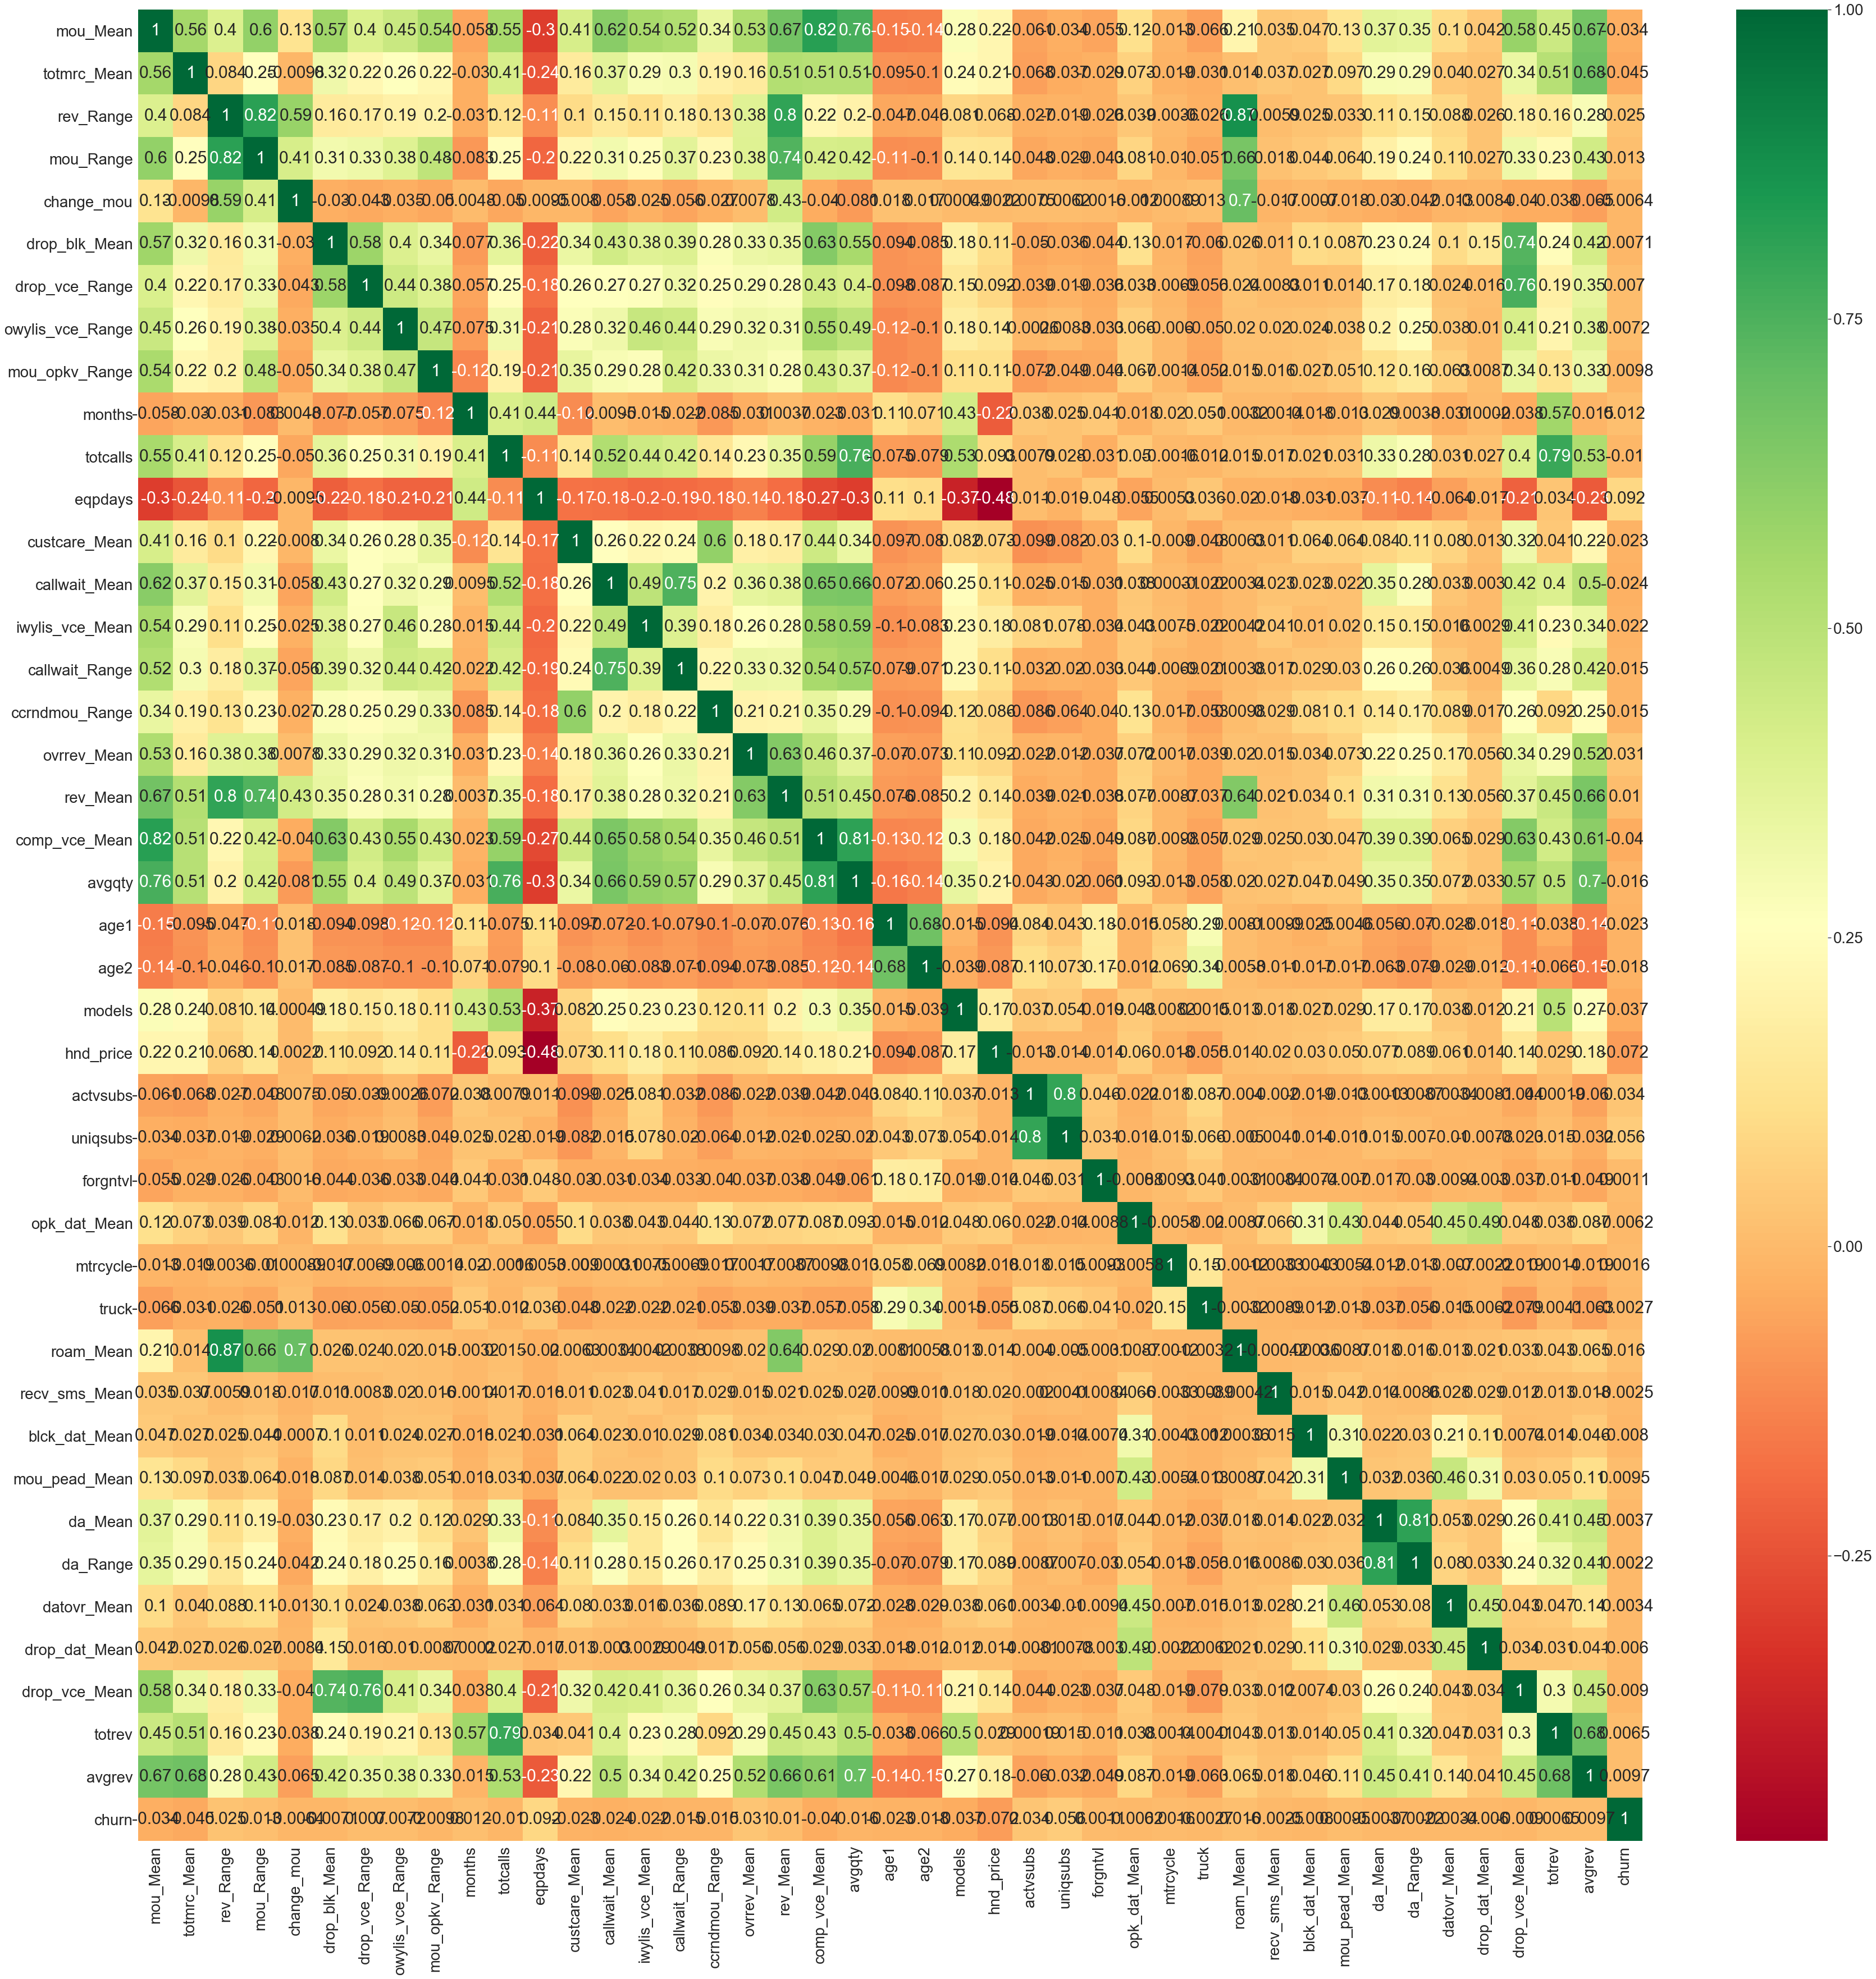

In [225]:
#get correlations of each features in dataset
sns.set(font_scale=2.5)
corrmat = pd.concat([X,Y], axis = 1).corr()
top_corr_features = corrmat.index
plt.figure(figsize=(60, 60))
#plot heat map
g=sns.heatmap(corrmat, xticklabels=corrmat.columns, yticklabels=corrmat.columns, annot=True,cmap="RdYlGn")

### Outliers removal

In [292]:
for col in X_new.columns:
    if X_new[col].dtype !='object':
        med = X_new[col].median()
        q1 = X_new[col].quantile(0.25)
        q3 = X_new[col].quantile(0.75)
        IQR = q3-q1 #Interquartile range
        fence_low  = q1-1.5*IQR
        fence_high = q3+1.5*IQR
        X_out_rv = X_new.loc[(X_new[col] > fence_low) & (X_new[col] < fence_high)]

#### Convert Catergorical variables into numerical variables

In [293]:
X_merge = X_out_rv.join(Y, how='inner', on=X_out_rv.index)

In [296]:
X = X_merge.loc[:,['mou_Mean', 'totmrc_Mean', 'rev_Range', 'mou_Range',
        'change_mou', 'drop_blk_Mean', 'drop_vce_Range', 'owylis_vce_Range',
        'mou_opkv_Range', 'months', 'totcalls', 'eqpdays', 'custcare_Mean',
        'callwait_Mean', 'iwylis_vce_Mean', 'callwait_Range', 'ccrndmou_Range',
        'ovrrev_Mean', 'rev_Mean', 'comp_vce_Mean', 'avgqty', 'crclscod',
        'asl_flag', 'prizm_social_one', 'area', 'refurb_new', 'hnd_webcap',
        'marital', 'ethnic', 'age1', 'age2', 'models', 'hnd_price', 'actvsubs',
        'uniqsubs', 'forgntvl', 'opk_dat_Mean', 'mtrcycle', 'truck',
        'roam_Mean', 'recv_sms_Mean', 'blck_dat_Mean', 'mou_pead_Mean',
        'car_buy', 'da_Mean', 'csa', 'da_Range', 'datovr_Mean', 'drop_dat_Mean',
        'drop_vce_Mean', 'totrev', 'avgrev']]
Y = X_merge.churn

In [297]:
X.shape, Y.shape

((12617, 52), (12617,))

In [298]:
# Categorical boolean mask
categorical_feature_mask = X.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = X.columns[categorical_feature_mask].tolist()

In [299]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

In [300]:
# apply le on categorical feature columns
X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

In [301]:
# Normalization of Datasets
sc = StandardScaler()
X_scale = pd.DataFrame(sc.fit_transform(X))

In [302]:
# import OneHotEncoder
#from sklearn.preprocessing import OneHotEncoder
# instantiate OneHotEncoder
#ohe = OneHotEncoder(categorical_features = categorical_feature_mask, sparse=False ) 
# categorical_features = boolean mask for categorical columns
# sparse = False output an array not sparse matrix
# apply OneHotEncoder on categorical feature columns
#X_ohe = ohe.fit_transform(X) # It returns an numpy array

# Handle Imbalance Dataset

In [303]:
Y.value_counts()

0    9666
1    2951
Name: churn, dtype: int64

In [304]:
X_scale.columns= X.columns
X_scale.head()

,mou_Mean,totmrc_Mean,rev_Range,mou_Range,change_mou,drop_blk_Mean,drop_vce_Range,owylis_vce_Range,mou_opkv_Range,months,...,mou_pead_Mean,car_buy,da_Mean,csa,da_Range,datovr_Mean,drop_dat_Mean,drop_vce_Mean,totrev,avgrev
0,0.870592,0.012837,2.255857,1.870859,-0.953933,2.731487,5.676567,3.511790,0.972618,-0.487748,...,-0.095394,0.864025,-0.173326,0.604778,0.186370,-0.001768,-0.078957,4.508853,-0.280093,0.048257
1,1.170389,0.991397,1.451685,1.330345,-1.746154,0.120804,-0.125233,-0.174604,-0.532275,0.120647,...,-0.095394,-1.157374,-0.326133,0.171700,-0.201405,-0.121241,-0.078957,-0.135957,0.757286,0.818762
2,-0.380344,-0.234254,-0.658150,-0.499087,0.234957,-0.676905,-0.619003,-0.030978,-0.158537,-0.690546,...,-0.095394,0.864025,-0.478941,1.619249,-0.589180,-0.121241,-0.078957,-0.670316,-0.820028,-0.920717
3,1.013460,0.256006,1.322602,0.357419,0.545588,0.314188,0.615422,1.740406,-0.322582,-0.589147,...,-0.095394,-1.157374,2.424399,-0.991085,1.349696,-0.121241,-0.078957,0.809447,0.403670,1.763512
4,-0.650330,0.378571,-0.493311,-0.199726,-0.024275,-0.652732,-0.619003,-0.701232,0.542017,-1.197542,...,-0.095394,-1.157374,-0.478941,-1.103804,-0.589180,-0.121241,-0.078957,-0.670316,-0.983903,-0.644475


### Split dataset into train & test 

In [305]:
x_train, x_test, y_train, y_test = train_test_split(X_scale, Y, test_size = 0.2, random_state=100, stratify=Y)

# Design Model 

In [306]:
# K- fold cross validation
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5)

In [328]:
Accuracy_logistic = []
Accuracy_RF = []

for train_idx, test_idx, in cv.split(x_train, y_train):
    X_train_sample = x_train.iloc[train_idx]
    Y_train_sample = y_train.iloc[train_idx]
    X_test_sample = x_train.iloc[test_idx]
    Y_test_sample =  y_train.iloc[test_idx]
    
    #Oversampling of minority class.
    X_train_oversampled, y_train_oversampled = SMOTE().fit_sample(X_train_sample, Y_train_sample)
    model_log = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
    
    model_rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
   
    model_log.fit(X_train_oversampled, y_train_oversampled)
    model_rf.fit(X_train_oversampled, y_train_oversampled)
    
    Accuracy_RF.append(accuracy_score(Y_test_sample, model_rf.predict(X_test_sample)))
    Accuracy_logistic.append(accuracy_score(Y_test_sample, model_log.predict(X_test_sample)))
def Average(lst): 
    return sum(lst) / len(lst)
print('Accuracy_RF :',Average(Accuracy_RF)*100)
print('Accuracy_logistic :',Average(Accuracy_logistic)*100)
          

Accuracy_RF : 64.06402800746721
Accuracy_logistic : 55.81084749390208


# Model evaluation

In [105]:
# model evaluation of Logistic regression

In [329]:
y_pred = model_log.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy :',accuracy)
# confusion matrix evaluation using logistic regression model
cm =confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:')
print(cm)


accuracy : 0.5459587955625991

Confusion Matrix:
[[1057  877]
 [ 269  321]]


In [324]:
# model evaluation of Random Forest

In [330]:
y_pred = model_rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy :',accuracy)
# confusion matrix evaluation using logistic regression model
cm =confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:')
print(cm)

accuracy : 0.625594294770206

Confusion Matrix:
[[1349  585]
 [ 360  230]]


## Hyperparameter tunning

In [ ]:
# find best estimator using Grid Search CV

In [308]:
#hyperparameter tunning for Logistic Regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2','l1'] }
Log_model = GridSearchCV(LogisticRegression(), param_grid)
Log_model.fit(X_train_oversampled,y_train_oversampled)

# Logistic regression best estimator
model_log = Log_model.best_estimator_

In [309]:
model_log

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [171]:
#hyperparameter tunning for Random forest
params = {"criterion": ["gini", "entropy"],
               'max_features': ['auto', 'sqrt', 'log2'],
               "max_depth": list(range(2,6,1)), 
              "min_samples_leaf": list(range(1,4,1))}
grid_rf = GridSearchCV(RandomForestClassifier(), params)
grid_rf.fit(X_train_oversampled,y_train_oversampled)

# tree best estimator
model_rf = grid_rf.best_estimator_



In [172]:
model_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Feature Importance

In [321]:
pd.Series(model_rf.feature_importances_,index = x_train.columns).sort_values(ascending=False)[:5]

eqpdays        0.123083
months         0.099802
models         0.064039
hnd_price      0.059404
ovrrev_Mean    0.054387
dtype: float64

In [320]:
coefs=model_log.coef_[0]
top = np.argpartition(coefs, -5)[-5:]
top_sorted=top[np.argsort(coefs[top_three])]
x_train.columns[top_sorted]

Index(['uniqsubs', 'ovrrev_Mean', 'callwait_Mean', 'drop_vce_Mean', 'eqpdays'], dtype='object')